In [143]:
import json
import numpy as np
import matplotlib.pyplot as plt
from utils.udp_util import extract_udp_prague_to_dataframe
from utils.plotter import  plot_siftr_graph

In [144]:
# File paths

file_cubic = '../data/udp_net_2025-06-06-14-07-14/iperf3_client_cubic_iperf3_d120.json'
file_udp = '../data/udp_net_2025-06-06-14-07-14/udp_prague_receiver_iperf3_d120.json'

duration = 1800  # Duration in seconds
filename="udp_net_2025-06-14-17-36-13"

file_udp = f'../data/{filename}/udp_prague_receiver_iperf3_d1800.json'
file_cubic = f'../data/{filename}/iperf3_client_cubic_iperf3_d1800.json'


# file_udp = '../data/udp_net_2025-06-10-13-27-49/udp_prague_receiver_iperf3_d1800.json'
# file_cubic = '../data/udp_net_2025-06-10-13-27-49/iperf3_client_cubic_iperf3_d1800.json'

utf = extract_udp_prague_to_dataframe(file_udp)

from utils.util import create_directory_if_not_exists
import os
graph_directory = os.path.join("./", "Graphs")
create_directory_if_not_exists(graph_directory)


Directory already exists: ./Graphs


In [145]:
utf[65:70]

,Time,Rcvd_Mbps,Sent_Mbps,RTT_ms,Mark_pct,Mark_Marked,Mark_Total,Lost_pct,Lost_Lost,Lost_Total
65,65.02,104.448,1.641,6.820,13.46,1255,9326,0.00,0,9326
66,66.02,89.513,1.407,2.845,7.00,560,7995,0.00,0,7995
67,67.02,64.666,1.016,7.192,0.33,19,5774,0.03,2,5774
68,68.02,38.116,0.599,10.146,0.00,0,3404,1.00,34,3404
69,69.02,55.123,0.866,7.635,0.51,25,4922,0.00,0,4922


In [146]:
import json
import numpy as np
import pandas as pd

def extract_data_df(filename):
    with open(filename) as f:
        data = json.load(f)

    records = []

    for interval in data['intervals']:
        record = {
            'time': interval['sum']['start'],
            'bitrate_mbps': interval['sum']['bits_per_second'] / 1_000_000
        }

        stream = interval['streams'][0]
        if 'rtt' in stream:
            record['rtt_time'] = stream['start']
            record['rtt_ms'] = stream['rtt'] / 1000.0  # µs to ms
        else:
            record['rtt_time'] = None
            record['rtt_ms'] = None

        records.append(record)

    df = pd.DataFrame(records)
    return df


In [147]:
import json
import pandas as pd

def extract_data_df(filename):
    with open(filename) as f:
        data = json.load(f)

    records = []

    for interval in data['intervals']:
        record = {
            'time': interval['sum']['start'],
            'bitrate_mbps': interval['sum']['bits_per_second'] / 1_000_000
        }

        stream = interval['streams'][0]

        # RTT
        if 'rtt' in stream:
            record['rtt_time'] = stream['start']
            record['rtt_ms'] = stream['rtt'] / 1000.0  # µs to ms
        else:
            record['rtt_time'] = None
            record['rtt_ms'] = None

        # Retransmits
        record['retransmits'] = stream.get('retransmits', None)

        # Send congestion window (bytes to KB)
        if 'snd_cwnd' in stream:
            record['snd_cwnd_kb'] = stream['snd_cwnd'] / 1024.0
        else:
            record['snd_cwnd_kb'] = None

        records.append(record)

    df = pd.DataFrame(records)
    return df


In [148]:



# Function to extract data from iperf3 JSON
def extract_data(filename):
    with open(filename) as f:
        data = json.load(f)

    times = []
    bitrates = []
    rtt_times = []
    rtts = []

    for interval in data['intervals']:
        times.append(interval['sum']['start'])
        bitrates.append(interval['sum']['bits_per_second'] / 1_000_000)  # Convert to Mbit/s

        stream = interval['streams'][0]
        if 'rtt' in stream:
            rtt_times.append(stream['start'])
            rtts.append(stream['rtt'] / 1000.0)  # µs to ms

    return np.array(times), np.array(bitrates), np.array(rtt_times), np.array(rtts)





import os
os.path.exists(file_cubic)

# Extract data
t_cubic, b_cubic, rt_cubic, rtt_cubic = extract_data(file_cubic)

In [149]:
tfcubic = extract_data_df(file_cubic)

In [150]:
tfcubic.describe()

,time,bitrate_mbps,rtt_time,rtt_ms,retransmits,snd_cwnd_kb
count,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000
mean,858.500177,112.482115,858.500177,53.133885,2.570431,206.748613
std,496.088221,40.210447,496.088221,413.096164,13.886154,62.877633
min,0.000000,0.000000,0.000000,1.128000,0.000000,1.414062
25%,429.250127,83.881255,429.250127,11.668750,0.000000,165.445312
50%,858.500240,115.190782,858.500240,14.891500,0.000000,205.039062
75%,1287.750103,136.968657,1287.750103,18.476750,0.000000,244.632812
max,1717.001147,366.997575,1717.001147,8303.755000,259.000000,477.953125


In [151]:
baseline_throuhgput_df = pd.read_csv('../router_configsv1.csv')

# Add 'Time' column starting from 0, increasing by 30 seconds
baseline_throuhgput_df['Time'] = [i * 30 for i in range(len(baseline_throuhgput_df))]


# Set Time as index and reindex to include every second from 0 to 120
baseline_throuhgput_df.set_index('Time', inplace=True)
# baseline_throuhgput_df = baseline_throuhgput_df.reindex(range(0, 121))  # Reindex from 0 to 120
baseline_throuhgput_df.ffill(inplace=True)  # Forward-fill the missing values

# Reset index so Time is a column again
baseline_throuhgput_df = baseline_throuhgput_df.reset_index().rename(columns={'index': 'Time'})

print(baseline_throuhgput_df)

    Time  thrpt  latency  ber_qpsk  loss_pct
0      0    184        6  0.117095        12
1     30    239        6  0.078310         8
2     60    189        6  0.112921        11
3     90    430        6  0.012877         1
4    120    336        6  0.034279         3
..   ...    ...      ...       ...       ...
56  1680    139        8  0.159525        16
57  1710    149        7  0.148882        15
58  1740    222        8  0.088952         9
59  1770    232        7  0.082738         8
60  1800    267        6  0.062667         6

[61 rows x 5 columns]


In [152]:
baseline_propagation_delay_df = pd.read_csv('../router_configsv1.csv')

# Add 'Time' column starting from 0, increasing by 30 seconds
baseline_propagation_delay_df['Time'] = [i * 30 for i in range(len(baseline_propagation_delay_df))]
baseline_propagation_delay_df.rename(columns={'latency': 'SmoothedRTT'}, inplace=True)

print(baseline_propagation_delay_df)

    thrpt  SmoothedRTT  ber_qpsk  loss_pct  Time
0     184            6  0.117095        12     0
1     239            6  0.078310         8    30
2     189            6  0.112921        11    60
3     430            6  0.012877         1    90
4     336            6  0.034279         3   120
..    ...          ...       ...       ...   ...
56    139            8  0.159525        16  1680
57    149            7  0.148882        15  1710
58    222            8  0.088952         9  1740
59    232            7  0.082738         8  1770
60    267            6  0.062667         6  1800

[61 rows x 5 columns]


In [153]:
utf.rename(columns={'RTT_ms': 'SmoothedRTT'}, inplace=True)
tfcubic.rename(columns={'rtt_ms': 'SmoothedRTT'}, inplace=True)


utf.rename(columns={'time': 'Time'}, inplace=True)
tfcubic.rename(columns={'time': 'Time'}, inplace=True)


utf.rename(columns={'Rcvd_Mbps': 'thrpt'}, inplace=True)
tfcubic.rename(columns={'bitrate_mbps': 'thrpt'}, inplace=True)


utf.rename(columns={'Lost_Lost': 'Lost_Packets'}, inplace=True)
tfcubic.rename(columns={'retransmits': 'Lost_Packets'}, inplace=True)

In [154]:
utf

,Time,thrpt,Sent_Mbps,SmoothedRTT,Mark_pct,Mark_Marked,Mark_Total,Lost_pct,Lost_Packets,Lost_Total
0,0.00,0.000,0.000,0.000,0.00,0,1,0.0,0,1
1,1.00,8.062,0.127,7.213,0.69,5,721,0.0,0,721
2,2.00,25.390,0.399,7.394,0.53,12,2267,0.0,0,2267
3,3.00,42.764,0.672,7.289,0.89,34,3822,0.0,0,3822
4,4.00,48.540,0.763,7.377,3.02,131,4335,0.0,0,4335
...,...,...,...,...,...,...,...,...,...,...
1704,1711.85,0.422,0.007,7350.762,0.00,0,42,0.0,0,42
1705,1712.97,0.338,0.005,8490.009,0.00,0,34,0.0,0,34
1706,1713.97,0.112,0.002,8260.217,0.00,0,10,0.0,0,10
1707,1714.97,74.426,1.170,61.752,0.99,66,6657,0.0,0,6657


In [155]:
tfcubic

,Time,thrpt,rtt_time,SmoothedRTT,Lost_Packets,snd_cwnd_kb
0,0.000000,160.396627,0.000000,12.180,0,238.976562
1,1.000116,129.278218,1.000116,20.385,0,284.226562
2,2.000110,115.202770,2.000110,22.387,0,319.578125
3,3.000111,115.202880,3.000111,15.802,0,251.703125
4,4.000111,115.202647,4.000111,21.231,0,294.125000
...,...,...,...,...,...,...
1713,1713.001094,104.956781,1713.001094,7.415,0,251.703125
1714,1714.000149,251.648670,1714.000149,9.996,0,332.304688
1715,1715.000187,94.309129,1715.000187,44.004,1,1.414062
1716,1716.000852,0.000000,1716.000852,149.004,1,357.757812


In [156]:
utf

,Time,thrpt,Sent_Mbps,SmoothedRTT,Mark_pct,Mark_Marked,Mark_Total,Lost_pct,Lost_Packets,Lost_Total
0,0.00,0.000,0.000,0.000,0.00,0,1,0.0,0,1
1,1.00,8.062,0.127,7.213,0.69,5,721,0.0,0,721
2,2.00,25.390,0.399,7.394,0.53,12,2267,0.0,0,2267
3,3.00,42.764,0.672,7.289,0.89,34,3822,0.0,0,3822
4,4.00,48.540,0.763,7.377,3.02,131,4335,0.0,0,4335
...,...,...,...,...,...,...,...,...,...,...
1704,1711.85,0.422,0.007,7350.762,0.00,0,42,0.0,0,42
1705,1712.97,0.338,0.005,8490.009,0.00,0,34,0.0,0,34
1706,1713.97,0.112,0.002,8260.217,0.00,0,10,0.0,0,10
1707,1714.97,74.426,1.170,61.752,0.99,66,6657,0.0,0,6657


In [157]:
(utf['SmoothedRTT'] > 50).value_counts()

SmoothedRTT
False    1686
True       23
Name: count, dtype: int64

In [158]:
# Calculate the median of the 'SmoothedRTT' column
median_rtt = utf['SmoothedRTT'].median()

# Replace outliers (values greater than 50) with the median
utf['SmoothedRTT'] = utf['SmoothedRTT'].apply(lambda x: median_rtt if x > 50 else x)

In [159]:
paths = {
    "Cubic": tfcubic,
    "L4S": utf,
    "Baseline Propagation Delay": baseline_propagation_delay_df
}

utf.to_csv("./graph_data/udp_prague_rtt.csv")
tfcubic.to_csv("./graph_data/cubic_rtt.csv")
baseline_propagation_delay_df.to_csv("./graph_data/baseline_propagation_delay_df.csv")

In [160]:
# Ensure 'Time' is int in all dataframes
baseline_propagation_delay_df['Time'] = baseline_propagation_delay_df['Time'].astype(int)
utf['Time'] = utf['Time'].astype(int)
tfcubic['Time'] = tfcubic['Time'].astype(int)

# Merge utf with baseline to compare SmoothedRTT
utf_merged = pd.merge(utf, baseline_propagation_delay_df, on='Time', suffixes=('_utf', '_baseline'))

# Filter utf where SmoothedRTT is greater than baseline
utf_filtered_rtt = utf_merged[utf_merged['SmoothedRTT_utf'] > utf_merged['SmoothedRTT_baseline']]

# Keep only utf columns
utf_filtered_rtt = utf_filtered_rtt[['Time', 'SmoothedRTT_utf']].rename(columns={'SmoothedRTT_utf': 'SmoothedRTT'})

# Similarly for tfcubic
tfcubic_merged = pd.merge(tfcubic, baseline_propagation_delay_df, on='Time', suffixes=('_tfcubic', '_baseline'))
tfcubic_filtered_rtt = tfcubic_merged[tfcubic_merged['SmoothedRTT_tfcubic'] > tfcubic_merged['SmoothedRTT_baseline']]
tfcubic_filtered_rtt = tfcubic_filtered_rtt[['Time', 'SmoothedRTT_tfcubic']].rename(columns={'SmoothedRTT_tfcubic': 'SmoothedRTT'})

# Results:
# utf_filtered_rtt and tfcubic_filtered_rtt only contain rows where RTT is greater than baseline at each Time



In [161]:
baseline_throuhgput_df = baseline_throuhgput_df[baseline_throuhgput_df['Time'] <= 1800]

baseline_propagation_delay_df = baseline_propagation_delay_df[baseline_propagation_delay_df['Time'] <= 1800]

In [162]:
import pandas as pd

# Assuming you already have tfcubic loaded
q1 = tfcubic['SmoothedRTT'].quantile(0.25)
q3 = tfcubic['SmoothedRTT'].quantile(0.75)
iqr = q3 - q1

# Define bounds for non-outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
tfcubic_cleaned = tfcubic[(tfcubic['SmoothedRTT'] >= lower_bound) & (tfcubic['SmoothedRTT'] <= upper_bound)]


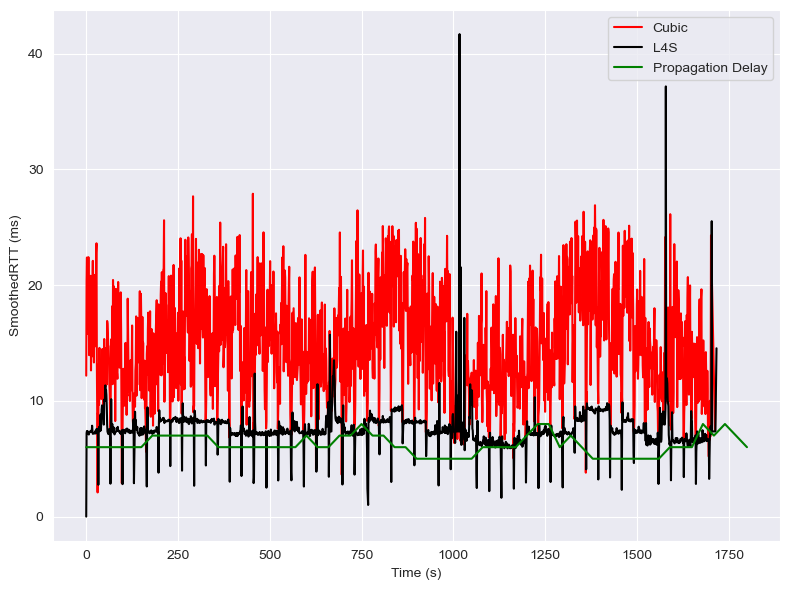

In [163]:
    # Define paths
paths = {
    "Cubic": tfcubic_cleaned,
    "L4S": utf,
    "Propagation Delay": baseline_propagation_delay_df
}


# paths = {
#     "Cubic": tfcubic_filtered_rtt,
#     "L4S": utf_filtered_rtt,
#     "Baseline Propagation Delay": baseline_propagation_delay_df
# }


scenario = str("RTT_UDPPraguevsCubic")

plot_siftr_graph(paths=paths,
                ycolumn="SmoothedRTT",
                title=f"{scenario} SmoothedRTT",
                xlabel="Time (s)",
                ylabel="SmoothedRTT (ms)",
                filename=f'{scenario}',
                graph_directory=graph_directory,
)

In [164]:
tfcubic['thrpt']

0       160.396627
1       129.278218
2       115.202770
3       115.202880
4       115.202647
           ...    
1713    104.956781
1714    251.648670
1715     94.309129
1716      0.000000
1717      0.000000
Name: thrpt, Length: 1718, dtype: float64

In [165]:
utf['thrpt']

0        0.000
1        8.062
2       25.390
3       42.764
4       48.540
         ...  
1704     0.422
1705     0.338
1706     0.112
1707    74.426
1708    21.728
Name: thrpt, Length: 1709, dtype: float64

In [166]:
tfcubic['Time'] = tfcubic['Time'].astype(int)

In [167]:
tfcubic['Time']

0          0
1          1
2          2
3          3
4          4
        ... 
1713    1713
1714    1714
1715    1715
1716    1716
1717    1717
Name: Time, Length: 1718, dtype: int32

In [168]:
utf['Time'] = utf['Time'].astype(int)

In [169]:
# tfcubic.set_index('Time', inplace=True)
# utf.set_index('Time', inplace=True)
# baseline_throuhgput_df.set_index('Time', inplace=True)

In [170]:

# Step 1: Forward fill existing NaNs
baseline_throuhgput_df = baseline_throuhgput_df.set_index('Time')

baseline_throuhgput_df.ffill(inplace=True)

# Step 2: Reindex to include every second
# Create new full second index range from min to max
full_index = pd.RangeIndex(start=baseline_throuhgput_df.index.min(),
                           stop=baseline_throuhgput_df.index.max() + 1,  # +1 to include last second
                           step=1)

# Step 3: Reindex and forward fill new rows
baseline_throuhgput_df = baseline_throuhgput_df.reindex(full_index).ffill()
baseline_throuhgput_df = baseline_throuhgput_df.reindex(baseline_throuhgput_df.index.astype(int))
baseline_throuhgput_df = baseline_throuhgput_df.reset_index().rename(columns={'index': 'Time'})


In [171]:
import pandas as pd

# Example dfs: baseline_throuhgput_df, utf, tfcubic

# Ensure 'Time' is int in all dataframes (optional step)
baseline_throuhgput_df['Time'] = baseline_throuhgput_df['Time'].astype(int)
utf['Time'] = utf['Time'].astype(int)
tfcubic['Time'] = tfcubic['Time'].astype(int)

# Merge utf with baseline on 'Time' to compare throughput
utf_merged = pd.merge(utf, baseline_throuhgput_df, on='Time', suffixes=('_utf', '_baseline'))

# Filter utf rows where utf throughput < baseline throughput
utf_filtered = utf_merged[utf_merged['thrpt_utf'] < utf_merged['thrpt_baseline']]

# Keep only original utf columns
utf_filtered = utf_filtered[['Time', 'thrpt_utf']].rename(columns={'thrpt_utf': 'thrpt'})

# Same for tfcubic
tfcubic_merged = pd.merge(tfcubic, baseline_throuhgput_df, on='Time', suffixes=('_tfcubic', '_baseline'))
tfcubic_filtered = tfcubic_merged[tfcubic_merged['thrpt_tfcubic'] < tfcubic_merged['thrpt_baseline']]
tfcubic_filtered = tfcubic_filtered[['Time', 'thrpt_tfcubic']].rename(columns={'thrpt_tfcubic': 'thrpt'})

# Now utf_filtered and tfcubic_filtered are filtered dataframes where throughput is lower than baseline at each Time

# Results:
# utf_filtered
# tfcubic_filtered


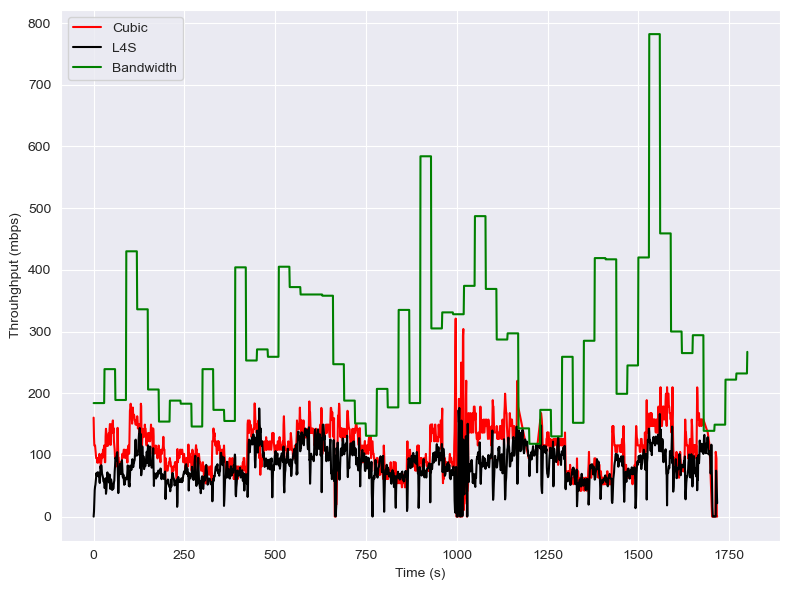

In [172]:
    # Define paths
paths = {
    "Cubic": tfcubic,
    "L4S": utf,
    "Bandwidth": baseline_throuhgput_df
}


paths = {
    "Cubic": tfcubic_filtered,
    "L4S": utf_filtered,
    "Bandwidth": baseline_throuhgput_df
}



scenario = str("Thrpt_UDPPraguevsCubic")

plot_siftr_graph(paths=paths,
                ycolumn="thrpt",
                title=f"{scenario} Throuhghput",
                xlabel="Time (s)",
                ylabel="Throuhghput (mbps)",
                filename=f'{scenario}',
                graph_directory=graph_directory,
)

In [173]:
baseline_throuhgput_df

,Time,thrpt,latency,ber_qpsk,loss_pct
0,0,184.0,6.0,0.117095,12.0
1,1,184.0,6.0,0.117095,12.0
2,2,184.0,6.0,0.117095,12.0
3,3,184.0,6.0,0.117095,12.0
4,4,184.0,6.0,0.117095,12.0
...,...,...,...,...,...
1796,1796,232.0,7.0,0.082738,8.0
1797,1797,232.0,7.0,0.082738,8.0
1798,1798,232.0,7.0,0.082738,8.0
1799,1799,232.0,7.0,0.082738,8.0


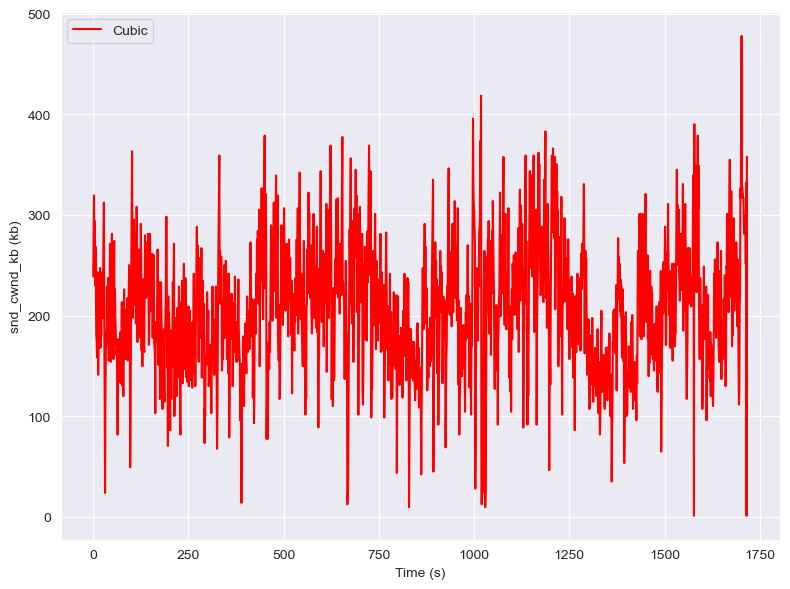

In [174]:
    # Define paths
paths = {
    "Cubic": tfcubic,
    # "L4S": utf,
    # "Bandwidth": baseline_throuhgput_df
}



scenario = str("snd_cwnd_UDPPraguevsCubic")

plot_siftr_graph(paths=paths,
                ycolumn="snd_cwnd_kb",
                title=f"{scenario} snd_cwnd_kb",
                xlabel="Time (s)",
                ylabel="snd_cwnd_kb (kb)",
                filename=f'{scenario}',
                graph_directory=graph_directory,
)

In [175]:
tfcubic[['Time', 'Lost_Packets']].to_csv("./graph_data/cubic_loss.csv", index=False)
utf[['Time', 'Lost_Packets']].to_csv("./graph_data/udp_prague_loss.csv", index=False)


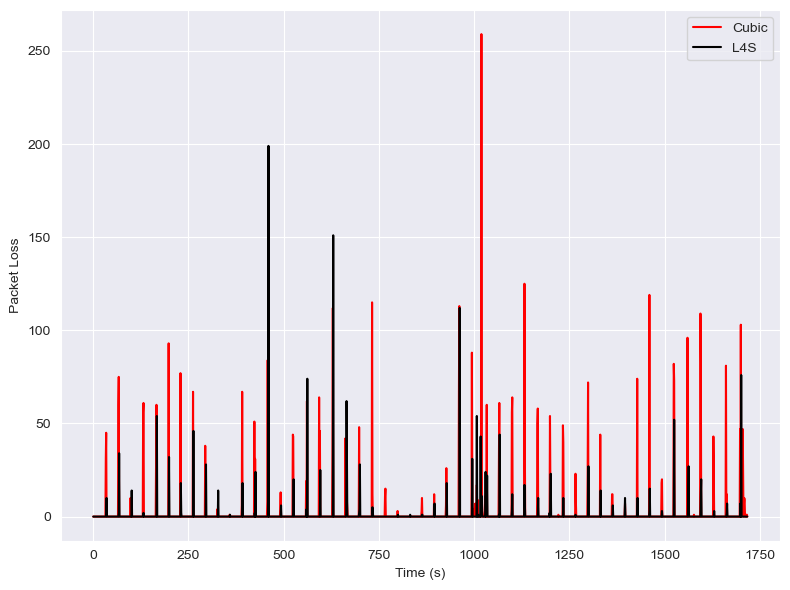

In [176]:
    # Define paths
paths = {
    "Cubic": tfcubic,
    "L4S": utf,
    # "Bandwidth": baseline_throuhgput_df
}



scenario = str("PktLoss_UDPPraguevsCubic")

plot_siftr_graph(paths=paths,
                ycolumn="Lost_Packets",
                title=f"{scenario} Packet Loss",
                xlabel="Time (s)",
                ylabel="Packet Loss",
                filename=f'{scenario}',
                graph_directory=graph_directory,
)

In [177]:

utf.rename(columns={'Lost_Packets': 'Loss'}, inplace=True)
tfcubic.rename(columns={'Lost_Packets': 'Loss'}, inplace=True)

In [178]:
tfcubic[['Time', 'Loss']].to_csv("./graph_data/cubic_loss.csv", index=False)
utf[['Time', 'Loss']].to_csv("./graph_data/udp_prague_loss.csv", index=False)


In [179]:
tfcubic[['Time', 'Loss']].to_csv("./graph_data/cubic_loss.csv", index=False)
utf[['Time', 'Loss']].to_csv("./graph_data/udp_prague_loss.csv", index=False)


In [180]:
utf.rename(columns={'thrpt': 'Throughput (Mbit/s)'}, inplace=True)
tfcubic.rename(columns={'thrpt': 'Throughput (Mbit/s)'}, inplace=True)
baseline_throuhgput_df.rename(columns={'thrpt': 'Throughput (Mbit/s)'}, inplace=True)

In [181]:
tfcubic[['Time', 'Throughput (Mbit/s)']].to_csv("./graph_data/cubic_thrpt.csv", index=False)
utf[['Time', 'Throughput (Mbit/s)']].to_csv("./graph_data/udp_prague_thrpt.csv", index=False)
baseline_throuhgput_df[['Time', 'Throughput (Mbit/s)']].to_csv("./graph_data/baseline_thrpt.csv", index=False)


In [182]:
#     # Define paths
# paths = {
#     # "Cubic": tfcubic,
#     "L4S": utf,
#     # "Bandwidth": baseline_throuhgput_df
# }



# scenario = str("Thrpt_UDPPraguevsCubic")

# plot_siftr_graph(paths=paths,
#                 ycolumn="Lost_Lost",
#                 title=f"{scenario} Lost_Lost",
#                 xlabel="Time (s)",
#                 ylabel="Lost_Lost",
#                 filename=f'{scenario}',
#                 graph_directory=graph_directory,
# )

In [183]:
#     # Define paths
# paths = {
#     "Cubic": tfcubic,
#     # "L4S": utf,
#     # "Bandwidth": baseline_throuhgput_df
# }



# scenario = str("Thrpt_UDPPraguevsCubic")

# plot_siftr_graph(paths=paths,
#                 ycolumn="retransmits",
#                 title=f"{scenario} retransmits",
#                 xlabel="Time (s)",
#                 ylabel="retransmits",
#                 filename=f'{scenario}',
#                 graph_directory=graph_directory,
# )